<a href="https://colab.research.google.com/github/ahmed192a/ImageProcessing-PatternRecognition/blob/main/P2.Vehicle-Detection/optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P5: Vehicle Detection and Tracking

## Import the necessary libraries

In [1]:
import os
if (not os.path.exists('./P5_Vehicle_Detection_and_Tracking.ipynb')):
  !git clone https://github.com/cdemutiis/Vehicle_Detection_and_Tracking.git
  %cd Vehicle_Detection_and_Tracking

Cloning into 'Vehicle_Detection_and_Tracking'...
remote: Enumerating objects: 17753, done.
remote: Total 17753 (delta 0), reused 0 (delta 0), pack-reused 17753
Receiving objects: 100% (17753/17753), 200.78 MiB | 38.39 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (17864/17864), done.
/content/Vehicle_Detection_and_Tracking


#Imports

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import glob
import time
from random import shuffle
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)4014080/45929032 bytes (8.7%)8019968/45929032 bytes (17.5%)12091392/45929032 bytes (26.3%)16343040/45929032 bytes (35.6%)20447232/45929032 bytes (44.5%)24403968/45929032 bytes (53.1%)28459008/45929032 bytes (62.0%)32555008/45929032 bytes (70.9%)36593664/45929032 bytes (79.7%)40624128/45929032 bytes (88.4%)44875776/45929032 bytes (97.7%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root

#Useful functions to be used in the image pipeline for Vehicle Detection and Tracking

In [3]:

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'BGR2LUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'BGR2HSV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'BGR2HLS':
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'BGR2YUV':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    if conv == 'RGB2BGR':
        return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell,pix_per_cell),
                                  cells_per_block=(cell_per_block,cell_per_block), 
                                  transform_sqrt=True, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell,pix_per_cell),
                       cells_per_block=(cell_per_block,cell_per_block),
                       transform_sqrt=True, 
                       visualize=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    img_feature = np.copy(img)
    return cv2.resize(img_feature, size).ravel()
                        
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#Find Car

In [44]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, boxes_sm, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cells_per_step, conv_color):
    img = img.astype(np.float32)/255
    heat_map = np.zeros_like(img[:,:,0], dtype=np.float32)
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv_color)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (int(imshape[1]/scale), int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # print(ctrans_tosearch.shape)


    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    # nxblocks = nxcells // cell_per_block
    # nyblocks = nycells // cell_per_block
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    # nblocks_per_window = (window // cell_per_block)-1 
    nblocks_per_window = (window // pix_per_cell) - 1 
    cells_per_step = cells_per_step #int(0.5 * ncells_per_window)  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    # print(hog1.shape)
    # print(nblocks_per_window)

    boxes_list = []
    if len(boxes_sm) != 0:
      for box in boxes_sm:
        # print(box)
        # print()
        ypos = int(box[1]/pix_per_cell)
        xpos = int(box[0]/pix_per_cell)
        
        hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        # print(hog_feat1.shape, hog_feat2.shape, hog_feat3.shape)
        # print(ypos, box[1])
        # print(xpos, box[0])
        # print(ctrans_tosearch[box[1]:box[1]+window, box[0]:box[0]+window].shape)
        # print(ctrans_tosearch.shape)
        subimg = cv2.resize(ctrans_tosearch[box[1]:box[1]+window, box[0]:box[0]+window], (64,64))
            
        # Get color features
        #spatial_features = bin_spatial(subimg, size=spatial_size)
        #hist_features = color_hist(subimg, nbins=hist_bins)

        # Scale features and make a prediction
        # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
        test_features = X_scaler.transform(hog_features.reshape(1, -1)) 
        # X_scaler.fit_transform(hog_features)   
        # test_features = X_scaler.transform(hog_features)    

        #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))  
                
        test_prediction  = svc.predict(test_features)
              
        if test_prediction == 1:
            xbox_left = int(box[0]*scale)
            ytop_draw = int(box[1]*scale)
            win_draw = int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
            # box = np.array([[xbox_left,ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])
            boxes_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            # heat_map[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1
    else:
      for xb in range(nxsteps):
          for yb in range(nysteps):
              ypos = yb*cells_per_step
              xpos = xb*cells_per_step
              # Extract HOG for this patch
              hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
              hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
              hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

              hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

              # print("else: " , hog_feat1.shape, hog_feat2.shape, hog_feat3.shape)

              xleft = xpos*pix_per_cell
              ytop = ypos*pix_per_cell

              # Extract the image patch
              subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
              # Get color features
              spatial_features = bin_spatial(subimg, size=spatial_size)
              hist_features = color_hist(subimg, nbins=hist_bins)

              # Scale features and make a prediction
              # test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)) 
              test_features = X_scaler.transform(hog_features.reshape(1, -1)) 
              # X_scaler.fit_transform(hog_features)   
              # test_features = X_scaler.transform(hog_features)    

              #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))  
                
              test_prediction  = svc.predict(test_features)
              
              if test_prediction == 1:
                  xbox_left = int(xleft*scale)
                  ytop_draw = int(ytop*scale)
                  win_draw = int(window*scale)
                  cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                  # box = np.array([[xbox_left,ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]])
                  boxes_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                  # heat_map[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1
    heat_map = add_heat(heat_map, boxes_list)
    return draw_img,boxes_list, heat_map

#Find Car utils

In [5]:
## Heat-map functions
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    box_list =[]
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_list.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, box_list

# Training utils

In [6]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, cspace='RGB',
                        spatial_size=(32, 32), hist_bins =32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                        spatial_enable=True, hist_enable=True, hog_enable=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_enable == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_enable == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_enable == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append((get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#Main Training

In [7]:
colorspace = 'YCrCb'        # Can be RGB, HSV, LUV, HLS, YUV, YCrCb       
orient = 10                 # HOG orientations
pix_per_cell = 8            # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel = "ALL"         # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)     # Spatial binning dimensions 
hist_bins = 16              # Number of histogram bins
spatial_feat = False         # Spatial features on or off
hist_feat = False            # Histogram features on or off
hog_feat = True             # HOG features on or off
y_start_stop = [400, 656]   # Min and max in y to search in slide_window()
scales = [1.0,1.5,2.0]      # Scale the image
cells_per_step = 2          # How many cells to step per sliding window
# Divide up into cars and notcars
# Read in car and non-car images
if os.path.exists("training_Model.pkl"):
  print()
  print('Found Previous Model')
  model_pickle = pickle.load(open('training_Model.pkl', 'rb'))
  svc = model_pickle['svc']
  X_scaler = model_pickle['scaler']
  orient = model_pickle['orient']
  pix_per_cell = model_pickle['pix_per_cell'] 
  cell_per_block = model_pickle['cell_per_block']
  spatial_size = model_pickle['spatial_size']
  hist_bins = model_pickle['hist_bins']
  colorspace = model_pickle['colorspace'] 
else:
  # Divide up into cars and notcars
  # Read in car and non-car images
  cars = glob.glob('training_data/vehicles/**/*.png',recursive=True)
#   shuffle(cars)
  notcars = glob.glob('training_data/non-vehicles/**/*.png',recursive=True)
#   shuffle(notcars)
  # notcars = notcars[:len(cars)]
  print("There are " + str(len(cars)) + " cars images in the training dataset")
  print("There are " + str(len(notcars)) + " not-cars images in the training dataset")




  t=time.time()
  car_features = extract_features(
                      cars, cspace=colorspace, 
                      spatial_size=spatial_size, hist_bins=hist_bins, 
                      orient=orient, pix_per_cell=pix_per_cell, 
                      cell_per_block=cell_per_block, 
                      hog_channel=hog_channel,spatial_enable=spatial_feat,
                      hist_enable=hist_feat, hog_enable=hog_feat)
  notcar_features = extract_features(
                      notcars, cspace=colorspace, 
                      spatial_size=spatial_size, hist_bins=hist_bins, 
                      orient=orient, pix_per_cell=pix_per_cell, 
                      cell_per_block=cell_per_block, 
                      hog_channel=hog_channel,spatial_enable=spatial_feat,
                      hist_enable=hist_feat, hog_enable=hog_feat)
  t2 = time.time()
  print(round(t2-t, 2), 'Seconds to extract HOG features...')
  # Create an array stack of feature vectors
  X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
  # Fit a per-column scaler
  X_scaler = StandardScaler().fit(X)
  # Apply the scaler to X
  scaled_X = X_scaler.transform(X)

  # Define the labels vector
  y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


  # Split up data into randomized training and test sets
  rand_state = np.random.randint(0, 100)
  X_train, X_test, y_train, y_test = train_test_split(
      scaled_X, y, test_size=0.2, random_state=rand_state)
  # Use a linear SVC 
  svc = LinearSVC()
  # Check the training time for the SVC
  t=time.time()
  svc.fit(X_train, y_train)
  t2 = time.time()
  print(round(t2-t, 2), 'Seconds to train SVC...')
  # Check the score of the SVC
  print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
  # Check the prediction time for a single sample
  t=time.time()
  n_predict = 10
  print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
  print('For these',n_predict, 'labels: ', y_test[0:n_predict])
  t2 = time.time()
  print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

  model_pickle = {}
  model_pickle['svc'] = svc
  model_pickle['scaler'] = X_scaler
  model_pickle['orient'] = orient
  model_pickle['pix_per_cell'] = pix_per_cell
  model_pickle['cell_per_block'] = cell_per_block
  model_pickle['spatial_size'] = spatial_size
  model_pickle['hist_bins'] = hist_bins
  model_pickle['colorspace'] = colorspace
  pickle.dump( model_pickle, open( "training_Model.pkl", "wb" ))
print('Configuration:')
print('-----------------------------------------------')
print(' Color space:             ', colorspace)
print(' Spatial binning enabled: ', spatial_feat)
print(' Spatial binning:         ', spatial_size)
print(' Histogram enabled:       ', hist_feat)
print(' Number histogram bins:   ', hist_bins)
print(' HOG enabled:             ', hog_feat)
print(' HOG orientations:        ', orient)
print(' HOG pixel per cell:      ', pix_per_cell)
print(' HOG cells per block:     ', cell_per_block)
print(' HOG channel:             ', hog_channel)
print(' Feature vector length:   ', len(X_train[0]))
print()
print('Train the classifier...', end='', flush=True)
print('Done')

There are 8826 cars images in the training dataset
There are 8996 not-cars images in the training dataset
102.34 Seconds to extract HOG features...
19.8 Seconds to train SVC...
Test Accuracy of SVC =  0.9849
My SVC predicts:  [1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
For these 10 labels:  [1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
0.00249 Seconds to predict 10 labels with SVC
Configuration:
-----------------------------------------------
 Color space:              YCrCb
 Spatial binning enabled:  False
 Spatial binning:          (32, 32)
 Histogram enabled:        False
 Number histogram bins:    16
 HOG enabled:              True
 HOG orientations:         10
 HOG pixel per cell:       8
 HOG cells per block:      2
 HOG channel:              ALL
 Feature vector length:    5880

Train the classifier...Done


#Image Pipeline utils

In [47]:
# This function makes sure that each processed image is saved in the 
# appropriate folder 
def save_img(img, folder, fname, stage_name, col_map):
    if fname != "None":
        if not os.path.exists(folder):
            os.makedirs(folder)
        if fname != "chosen":
            fname = fname.split('/')[1]
            fname = fname.split('.')[0]
            new_filename = fname + "_" + stage_name + '.jpg'
        else:
            new_filename = stage_name + '.jpg'
            
        mpimg.imsave(folder + "/" + new_filename, img,cmap=col_map)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, (bbox[0][0],bbox[0][1]), (bbox[1][0],bbox[1][1]), color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def corners(listt, list_of_boxes, y_start, scale, img_size, pix_per_cell):
  sit = set(listt)
  # box_size = int(64 / scale)
  box_size = 64
  limit_x = int((int(img_size[1] / 64) * 64) / scale)
  limit_y = int((int(img_size[0] / 64) * 64) / scale)
  for box in list_of_boxes:
    xtop_corner = int(box[0][0] / scale)
    xtop_corner = xtop_corner - xtop_corner % pix_per_cell
    ytop_corner = int((box[0][1] - y_start) / scale)
    ytop_corner = ytop_corner - ytop_corner % pix_per_cell
    # print(xtop_corner)
    # print(ytop_corner)
    sit.add((xtop_corner, ytop_corner))
# first row
    if(ytop_corner - box_size >= 0):
      sit.add((xtop_corner, ytop_corner - box_size))
      if(xtop_corner + box_size * 2 <= limit_x):
        sit.add((xtop_corner + box_size, ytop_corner - box_size))
      if(xtop_corner - box_size >= 0):
        sit.add((xtop_corner - box_size, ytop_corner - box_size))

    if(xtop_corner + box_size * 2 <= limit_x):
      sit.add((xtop_corner + box_size, ytop_corner))
      if(ytop_corner - box_size >= 0):
        sit.add((xtop_corner + box_size, ytop_corner - box_size))
      if(ytop_corner + box_size * 2 <= limit_y):
        sit.add((xtop_corner + box_size, ytop_corner + box_size))
      
    if(ytop_corner + box_size * 2 <= limit_y):
      sit.add((xtop_corner, ytop_corner + box_size))
      if(xtop_corner - box_size >= 0):
        sit.add((xtop_corner - box_size, ytop_corner + box_size))
      if(xtop_corner + box_size * 2 <= limit_x):
        sit.add((xtop_corner + box_size, ytop_corner + box_size))

    if(xtop_corner - box_size >= 0):
      sit.add((xtop_corner - box_size, ytop_corner))
      if(ytop_corner + box_size * 2 <= limit_y):
        sit.add((xtop_corner - box_size, ytop_corner + box_size))
      if(ytop_corner - box_size >= 0):
        sit.add((xtop_corner - box_size, ytop_corner - box_size))
    
  return list(sit)

#image Pipeline

In [48]:
ystart = y_start_stop[0]   
ystop = y_start_stop[1]
first_frame = True
count_f = 0
def process_image(image):
    result = image_pipeline(image, "None")
    return result
# This function processes each individual image coming from the video stream 
# and estimates where the cars are
def image_pipeline(img, fname):

    global heat_previous, first_frame, count_f #, boxes_previous, labels_prev
    heat = np.zeros_like(img[:,:,0])
    box_sm=[]
    if(first_frame == True):
        heat_previous =[]
        heat_previous.append(np.zeros_like(img[:,:,0]).astype(np.float))
        heat_previous.append(np.zeros_like(img[:,:,0]).astype(np.float))
        heat_previous.append(np.zeros_like(img[:,:,0]).astype(np.float))
        boxes_previous =  np.zeros_like(img[:,:,0]).astype(np.float)
        first_frame = False  
        count_f = 1
    else:
      count_f += 1

    boxes_list_1 = []
    # for scale in scales:
    for scale in [1,1.5]:
      # print(boxes_list_1)
      box_sm += corners(box_sm, boxes_list_1 ,ystart, scale, img[y_start_stop[0]:y_start_stop[1],:,0].shape, pix_per_cell)
      print(box_sm)
      # print(len(box_sm))
      out_img, boxes_list_1, heat_1 = find_cars(img, y_start_stop[0] ,
                                          y_start_stop[1], box_sm, scale, 
                                          svc, X_scaler, orient, 
                                          pix_per_cell, cell_per_block, 
                                          spatial_size, hist_bins, 
                                          cells_per_step, "RGB2YCrCb")
      
      heat = np.add(heat, heat_1)
      # plt.imshow(out_img)
      # plt.show()


    # Apply threshold to help remove false positives
    if fname == "None" :  
      heat = np.add(heat_previous[0]*0.6,heat)
      heat = np.add(heat_previous[1]*0.4,heat)
      heat = np.add(heat_previous[2]*0.2,heat)
      heat = apply_threshold(heat,2)
      heat_previous[2] = heat_previous[1]
      heat_previous[1] = heat_previous[0]
      heat_previous[0] = heat
    elif fname != "None":
        heat = apply_threshold(heat,2)

    heat = np.clip(heat, 0, 1)
    labels = label(heat)
    heat_img, bbox_list = draw_labeled_bboxes(np.copy(img), labels)
    # print(bbox_list)
    return heat_img

# Test Images

[]
(256, 1280, 3)
(31, 159, 2, 2, 10)
7
584
8
704
8
712
0
712
16
720
0
752
16
[(776, 0), (712, 64), (648, 0), (720, 0), (784, 64), (656, 64), (640, 72), (704, 8), (768, 72), (752, 80), (688, 16), (776, 80), (648, 72), (584, 8), (520, 72), (776, 16), (712, 80), (648, 16), (712, 0), (776, 64), (648, 64), (648, 80), (784, 0), (720, 64), (656, 0), (704, 72), (768, 8), (640, 8), (752, 16), (688, 80), (584, 72), (648, 8), (520, 8), (712, 16)]
(170, 853, 3)
(20, 105, 2, 2, 10)
7
CPU times: user 1.46 s, sys: 54.7 ms, total: 1.51 s
Wall time: 1.47 s


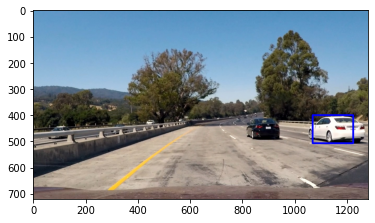

[]
(256, 1280, 3)
(31, 159, 2, 2, 10)
7
576
0
744
0
[(640, 64), (576, 64), (640, 0), (576, 0), (512, 64), (512, 0), (744, 0), (744, 64), (680, 64), (680, 0)]
(170, 853, 3)
(20, 105, 2, 2, 10)
7
CPU times: user 1.54 s, sys: 125 ms, total: 1.66 s
Wall time: 1.58 s


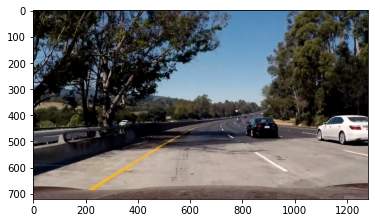

[]
(256, 1280, 3)
(31, 159, 2, 2, 10)
7
[]
(170, 853, 3)
(20, 105, 2, 2, 10)
7
CPU times: user 1.78 s, sys: 72.5 ms, total: 1.85 s
Wall time: 1.78 s


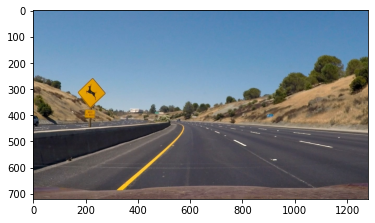

[]
(256, 1280, 3)
(31, 159, 2, 2, 10)
7
552
16
672
16
680
8
680
16
752
16
[(744, 72), (680, 8), (616, 72), (616, 16), (488, 16), (552, 80), (744, 16), (680, 80), (752, 80), (688, 16), (672, 16), (736, 80), (608, 80), (680, 72), (616, 8), (744, 8), (616, 80), (488, 80), (552, 16), (680, 16), (744, 80), (752, 16), (688, 80), (736, 16), (672, 80), (608, 16)]
(170, 853, 3)
(20, 105, 2, 2, 10)
7
CPU times: user 1.45 s, sys: 61.9 ms, total: 1.51 s
Wall time: 1.46 s


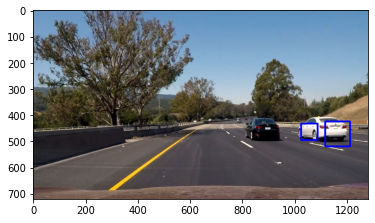

[]
(256, 1280, 3)
(31, 159, 2, 2, 10)
7
72
32
712
0
744
8
[(648, 0), (136, 32), (8, 96), (72, 32), (72, 96), (136, 96), (8, 32), (712, 0), (776, 0), (776, 64), (712, 64), (648, 64), (744, 8), (744, 72), (680, 72), (680, 8)]
(170, 853, 3)
(20, 105, 2, 2, 10)
7
CPU times: user 1.43 s, sys: 49.9 ms, total: 1.48 s
Wall time: 1.43 s


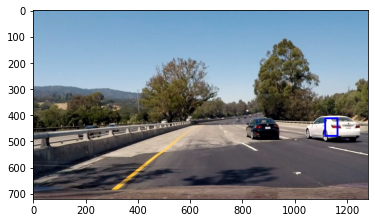

[]
(256, 1280, 3)
(31, 159, 2, 2, 10)
7
592
8
[(656, 72), (592, 8), (528, 72), (592, 72), (656, 8), (528, 8)]
(170, 853, 3)
(20, 105, 2, 2, 10)
7
CPU times: user 1.52 s, sys: 102 ms, total: 1.63 s
Wall time: 1.55 s


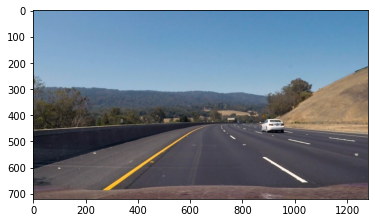

In [49]:
# Create the output_images directory 
if not os.path.exists("output_images"):
    os.makedirs("output_images")

# Read in and make a list of the test images
test_images = glob.glob('/content/Vehicle_Detection_and_Tracking/test_images/*.jpg')

for fname in test_images:
    # read in each image
    img = plt.imread(fname)
    first_frame = True
    %time result = image_pipeline(img, fname)
    plt.imshow(result)
    plt.show()

## Test on Videos

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
test_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4").subclip(0,1)
first_frame = True
test_clip = clip1.fl_image(process_image) 
%time test_clip.write_videofile(test_output, audio=False)

In [ ]:
project_output = 'Ahmed_project_video_output.mp4'
clip2 = VideoFileClip("project_video.mp4").subclip(0,30)
first_frame = True
project_clip = clip2.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)